In [2]:
import tensorflow as tf
import numpy
import scipy.io
import pandas
import os
from matplotlib import pyplot
%matplotlib inline

#carico file dati
percorsoFile = "/home/protoss/Documenti/TESI/DATI/peaks.mat"
#print(picchi.shape)
#picchi[0]
#nb: picchi ha 0-tempi
#              1-frequenze
#              4-pesi

#ora popolo il dataframe
tabella = pandas.DataFrame(scipy.io.loadmat(percorsoFile)['PEAKS'])
tabella.drop(tabella.columns[[2, 3]], axis = 1, inplace=True)
tabella.columns = ["tempi", "frequenze","pesi"]

#fascia di sicurezza
securbelt = 4000

headerFreq= scipy.io.loadmat(percorsoFile)['hm_job'][0,0]['fr'][0]
headerSpindown = scipy.io.loadmat(percorsoFile)['hm_job'][0,0]['sd'][0]
epoca = tf.constant(scipy.io.loadmat(percorsoFile)['basic_info'][0,0]['epoch'][0,0])

#metto qui come variabile globale, è la stessa cosa di nstepFrequenze TODO PESSIMO DA SISTEMARE!
numin = headerFreq[0]
numax = headerFreq[3]
enh = headerFreq[2]
stepnu = headerFreq[1]
stepnuraffinato = stepnu/enh

nuIn = numin-stepnu/2-stepnuraffinato
nuFin = numax+stepnu/2+stepnuraffinato

nColumns = (numpy.ceil((nuFin-nuIn)/stepnuraffinato)+securbelt).astype(numpy.int32)
    
print(nColumns)


#DA QUI comincio a usare tf
#frequenze
minFreq = tf.constant(headerFreq[0], name = "minFreq")
maxFreq = tf.constant(headerFreq[3], name = "maxFreq")
enhancement = tf.constant(headerFreq[2], name = "enhancement")
stepFrequenza = tf.constant(headerFreq[1], name = "stepFrequenza")
stepFreqRaffinato = stepFrequenza/enhancement


freqIniz = minFreq- stepFrequenza/2 - stepFreqRaffinato
freqFin = maxFreq + stepFrequenza/2 + stepFreqRaffinato

nstepFrequenze = (freqFin-freqIniz)/stepFreqRaffinato
nstepFrequenze = tf.cast(nstepFrequenze, dtype=tf.int32, name = "numstepsFreq")
nstepFrequenze = nstepFrequenze+securbelt

# riarrangio gli array in modo che abbia i dati 
# nel formato che voglio io
frequenze = tf.constant(tabella['frequenze'].values, name = "freqs")
frequenze = ((frequenze-freqIniz)/stepFreqRaffinato)-tf.round(enhancement/2+0.001)
freqSize = tf.size(frequenze)

tempi = tf.constant(tabella['tempi'].values, name = "tempi")
tempi = tempi-epoca
tempi = ((tempi)*3600*24/stepFreqRaffinato)

pesi = tf.constant(tabella['pesi'].values, name = "pesi")

#spindown
spindownIniz = tf.constant(headerSpindown[0], name = "Tdotiniz")
stepSpindown = tf.constant(headerSpindown[1], name = "Tdotstep")
nstepSpindown = tf.constant(headerSpindown[2], name = "nstepsTdot")

#nstepSpindown = 85
spindowns = tf.range(0.0, nstepSpindown,dtype=tf.float64, name = "spindowns")
spindowns = tf.multiply(spindowns,stepSpindown)
spindowns = tf.add(spindowns, spindownIniz)
# così ho i tre array delle tre grandezze

#stepIesimo = 0
nRows = tf.cast(nstepSpindown, dtype=tf.int64)

pesi = tf.reshape(pesi,(1,tf.size(pesi)))
pesi = pesi[0]
nRows = tf.constant(nstepSpindown, dtype=tf.int32)
nColumns = nstepFrequenze

def mapnonVar(stepIesimo):
    sdTimed = tf.multiply(spindowns[stepIesimo], tempi, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenze-sdTimed+securbelt/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int32)
    
    valori = tf.bincount(appoggio,weights=pesi)

    zeriDopo = tf.zeros([nColumns - tf.size(valori)], dtype=tf.float32)
    
    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return riga

imagenonVar = tf.map_fn(mapnonVar, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=24)

%time image = sessione.run(imagenonVar)
sessione = tf.Session(config=tf.ConfigProto(log_device_placement=True))

run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

start = time.time()
image = sessione.run(imageconSparse, options=run_options, run_metadata=run_metadata)
stop = time.time()
print(stop-start)


    # Create the Timeline object, and write it to a json
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open('timelineconSparse.json', 'w') as f:
	f.write(ctf)

16300


NameError: name 'time' is not defined

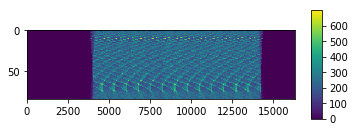

In [3]:
%matplotlib inline
#pyplot.figure(figsize=(100, 30))
a = pyplot.imshow(image, aspect = 50)
pyplot.colorbar(shrink = 0.5,aspect = 10)

In [1]:
semiLarghezza = numpy.round(enh/2+0.001).astype(int)
image[:,semiLarghezza*2:nColumns]=image[:,semiLarghezza*2:nColumns]-image[:,0:nColumns - semiLarghezza*2]
image = numpy.cumsum(image, axis = 1)

%matplotlib inline
pyplot.figure(figsize=(100, 30))
a = pyplot.imshow(image, aspect = 50)
pyplot.colorbar(shrink = 0.5,aspect = 10)

NameError: name 'numpy' is not defined

<function matplotlib.pyplot.show>

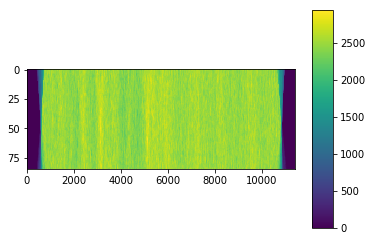

In [5]:
#confronto con originale

percorsoFile = "originale/concumsum.mat"
#percorsoFile = "originale/senzacumsum.mat"
immagineOriginale = scipy.io.loadmat(percorsoFile)['binh_df0']

percorsoFile = "debugExamples/concumsumDB.mat"
imgOrigDB = scipy.io.loadmat(percorsoFile)['binh_df0']

#pyplot.figure(figsize=(100, 30))
pyplot.imshow(immagineOriginale[:,3400:nColumns-1500],
              #cmap='gray',
              aspect=50)
pyplot.colorbar(shrink = 1,aspect = 10)
#pyplot.colorbar(immagine)
pyplot.show

(array([ 0,  0,  0, ..., 84, 84, 84]), array([ 3797,  3798,  3812, ..., 16297, 16298, 16299]))


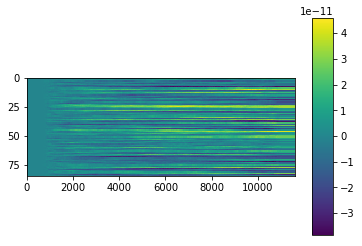

In [6]:
miaVSoriginale = image - immagineOriginale
#miaVSoriginale = immagineOriginale - imageParalled
#matlabVSoriginale = immagineOriginale - imgOrigDB
#pyplot.figure(figsize=(100, 30))

#verificadoppia = miaVSoriginale - matlabVSoriginale
pyplot.imshow(miaVSoriginale[:,3200:nColumns-1500],aspect=50)
pyplot.colorbar(shrink = 1,aspect = 10)
print(numpy.nonzero(miaVSoriginale))

In [ ]:
#prima prova con variabile e bincount che non riesco a far girare
#NB al momento bincount non va su gpu
def mapHough(stepIesimo):
    sdTimed = tf.multiply(spindowns[stepIesimo], tempi)
    appoggio = tf.round(frequenze-sdTimed+securbelt/2)
    appoggio = tf.cast(appoggio, dtype=tf.int32)

    row = tf.zeros([nColumns], dtype=tf.float64)
    hough = tf.Variable(row)

    valori = tf.bincount(appoggio,weights=pesi)
    nonzeri = tf.not_equal(valori, 0) 
    nonzeriId = tf.where(nonzeri)
    valori = tf.gather(valori,nonzeriId) #non so perché lo reshapa da riga a colonna aumentandogli il rank

    indici = tf.unique(appoggio)

    hough = tf.scatter_update(hough,indici[0],valori[:,0])
    
    return hough

image = tf.map_fn(mapHough, tf.range(0, nColumns), dtype=tf.float64)

init = tf.global_variables_initializer()
sessione.run(init)


%time imageMapped = sessione.run(image)
#print(sessione.run(valori[:,0]))

In [ ]:
#seconda prova senza variabile che gira molto veloce
#ma bincount non ha supporto gpu
nRows = tf.constant(nstepSpindown, dtype=tf.int32)
nColumns = nstepFrequenze

def mapnonVar(stepIesimo):
    sdTimed = tf.multiply(spindowns[stepIesimo], tempi, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenze-sdTimed+securbelt/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int32)
    
    valori = tf.bincount(appoggio,weights=pesi)

    zeriDopo = tf.zeros([nColumns - tf.size(valori)], dtype=tf.float32)
    
    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return riga

imagenonVar = tf.map_fn(mapnonVar, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=24)

%time image = sessione.run(imagenonVar)

In [8]:
# terza prova con sparse che va molto lento per colpa di sparse reorder, ma dà imagine perfetta
def mapconSparse(stepIesimo):
    sdTimed = tf.multiply(spindowns[stepIesimo], tempi, name = "Tdotpert")
    
    positions = tf.round(frequenze-sdTimed+securbelt/2, name = "appoggioperindici")
    positions = tf.cast(positions, dtype=tf.int32)
    positions = tf.reshape(positions, (1,tf.size(positions)))
    
    riga= tf.ones([tf.size(positions)])
    riga = tf.reshape(riga, (1,tf.size(riga)))
    righe = riga[0]
    colonne = positions[0]
    
    coordinate = tf.stack([tf.cast(righe,dtype=tf.int64),tf.cast(colonne,dtype=tf.int64)],1)
    
    shape=[nRows,nColumns]
    matrice = tf.SparseTensor(coordinate, pesi, shape)
    matrice = tf.sparse_reorder(matrice)
    coordinate = tf.cast(matrice.indices, tf.int32)


    coo, idx = tf.unique(coordinate[:,1])
    values = tf.segment_sum(matrice.values, idx)

    immagine = tf.sparse_to_dense(coo, [nColumns], values)
    #immagine = tf.cast(immagine, dtype=tf.float32)
    return immagine


imageconSparse = tf.map_fn(mapconSparse, tf.range(0, nRows), dtype=tf.float64)

%time image = sessione.run(imageconSparse)


16300
16300
SparseTensorValue(indices=array([[    1,  3957],
       [    1,  4067],
       [    1,  4347],
       ..., 
       [    1, 12786],
       [    1, 13466],
       [    1, 14036]]), values=array([ 0.73529603,  0.73529603,  0.73529603, ...,  0.03207786,
        0.03207786,  0.03207786]), dense_shape=array([   85, 16300]))
SparseTensorValue(indices=array([[    1,  3797],
       [    1,  3797],
       [    1,  3797],
       ..., 
       [    1, 14366],
       [    1, 14366],
       [    1, 14366]]), values=array([ 1.6803319 ,  1.2932507 ,  0.93966209, ...,  0.94091626,
        1.0763971 ,  0.28308942]), dense_shape=array([   85, 16300]))
CPU times: user 2.03 s, sys: 112 ms, total: 2.14 s
Wall time: 1.62 s


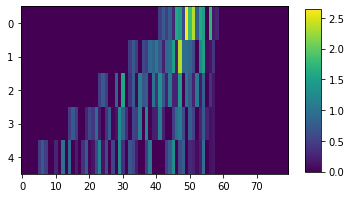

In [4]:
#quarta prova con unsorted segment sum
#programma semplificato per test e debug
import numpy
import tensorflow as tf
from tensorflow.python.client import timeline
from matplotlib import pyplot

#first i build a matrix of some x positions vs time datas in a sparse format
matrix = numpy.random.randint(2, size = 100).astype(float).reshape(10,10)
x = numpy.nonzero(matrix)[0]
times = numpy.nonzero(matrix)[1]
weights = numpy.random.rand(x.size)

#then i define an array of y positions
nStepsY = 5
y = numpy.arange(1,nStepsY+1)

nRows = nStepsY
nColumns = 80

x = tf.constant(x, dtype = tf.float32)
times = tf.constant(times, dtype = tf.float32)
weights = tf.constant(weights, dtype = tf.float32)
y = tf.constant(y, dtype = tf.float32)

def itermatrix(ithStep):
    yTimed = tf.multiply(y[ithStep],times)
    positions = tf.round((x-yTimed)+50)
    positions = tf.cast(positions, dtype=tf.int32)
    values = tf.math.unsorted_segment_sum(weights, positions, nColumns)
   
    return values

image = tf.map_fn(itermatrix, tf.range(0,nRows), dtype=tf.float32)



%matplotlib inline
pyplot.imshow(image, aspect = 10)
pyplot.colorbar(shrink = 0.75,aspect = 10)

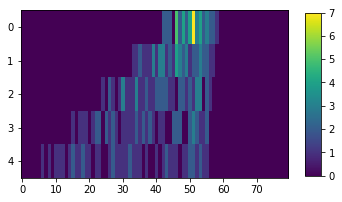

In [25]:
#quinta prova con histogram
#per ora semplificato
#programma semplificato per test e debug
#non so come mettere i pesi
import numpy
import tensorflow as tf
from tensorflow.python.client import timeline
from matplotlib import pyplot

#first i build a matrix of some x positions vs time datas in a sparse format
matrix = numpy.random.randint(2, size = 100).astype(float).reshape(10,10)
x = numpy.nonzero(matrix)[0]
times = numpy.nonzero(matrix)[1]
weights = numpy.random.rand(x.size)

#then i define an array of y positions
nStepsY = 5
y = numpy.arange(1,nStepsY+1)

nRows = nStepsY
nColumns = 80

x = tf.constant(x, dtype = tf.float32)
times = tf.constant(times, dtype = tf.float32)
weights = tf.constant(weights, dtype = tf.float32)
y = tf.constant(y, dtype = tf.float32)


def itermatrix(ithStep):
    yTimed = tf.multiply(y[ithStep],times)

    positions = tf.round((x-yTimed)+50)
#    positions = tf.multiply(positions,weights)
    #positions = tf.cast(positions, dtype=tf.int32)
    posbin = [0.0,80.0]
    
    
    values = tf.histogram_fixed_width(positions, posbin, 80, dtype = tf.float32)
    
    #each iteration of "values" has different size, depending on the binning
    #so i put some zeros after the values tensor
    #in order to have each row of the same size: 80
    #zerosAfter= tf.zeros([nColumns-tf.size(values)],dtype=tf.float32)
    #row = tf.concat([values,zerosAfter],0)
    return values

imageMapped = tf.map_fn(itermatrix, tf.range(0,nRows), dtype=tf.float32)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

image = sess.run(imageMapped, options=run_options, run_metadata=run_metadata)

    # Create the Timeline object, and write it to a json
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open('timelineDB.json', 'w') as f:
	f.write(ctf)

%matplotlib inline
pyplot.imshow(image, aspect = 10)
pyplot.colorbar(shrink = 0.75,aspect = 10)

In [ ]:
#quinta prova fully vectorial
#per ora semplificato
#programma semplificato per test e debug

#quarta prova con histogram
#per ora semplificato
#programma semplificato per test e debug
#non so come mettere i pesi
import numpy
import tensorflow as tf
from tensorflow.python.client import timeline
from matplotlib import pyplot

#first i build a matrix of some x positions vs time datas in a sparse format
matrix = numpy.random.randint(2, size = 100).astype(float).reshape(10,10)
x = numpy.nonzero(matrix)[0]
times = numpy.nonzero(matrix)[1]
weights = numpy.random.rand(x.size)

#then i define an array of y positions
nStepsY = 5
y = numpy.arange(1,nStepsY+1)

nRows = nStepsY
nColumns = 80

x = tf.constant(x, dtype = tf.float32)
times = tf.constant(times, dtype = tf.float32)
weights = tf.constant(weights, dtype = tf.float32)
y = tf.constant(y, dtype = tf.float32)


def itermatrix(ithStep):
    yTimed = tf.multiply(y[ithStep],times)

    positions = tf.round((x-yTimed)+50)
#    positions = tf.multiply(positions,weights)
    #positions = tf.cast(positions, dtype=tf.int32)
    posbin = [0.0,80.0]
    
    
    values = tf.histogram_fixed_width(positions, posbin, 80, dtype = tf.float32)
    
    #each iteration of "values" has different size, depending on the binning
    #so i put some zeros after the values tensor
    #in order to have each row of the same size: 80
    #zerosAfter= tf.zeros([nColumns-tf.size(values)],dtype=tf.float32)
    #row = tf.concat([values,zerosAfter],0)
    return values

imageMapped = tf.map_fn(itermatrix, tf.range(0,nRows), dtype=tf.float32)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

image = sess.run(imageMapped, options=run_options, run_metadata=run_metadata)

    # Create the Timeline object, and write it to a json
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open('timelineDB.json', 'w') as f:
	f.write(ctf)

%matplotlib inline
pyplot.imshow(image, aspect = 10)
pyplot.colorbar(shrink = 0.75,aspect = 10)


https://www.tensorflow.org/api_guides/python/sparse_ops  
https://docs.scipy.org/doc/scipy-0.18.1/reference/tutorial/io.html  
http://poquitopicante.blogspot.it/2014/05/loading-matlab-mat-file-into-pandas.html  
http://stackoverflow.com/questions/874461/read-mat-files-in-python  
https://it.wikipedia.org/wiki/Matrice_sparsa  
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html  
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html  

In [ ]:
#Programma semplificato per debug e domande

